# DeepFool攻击，针对resnet18，Mnist

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision.models as models
from torch.autograd import Variable
from torchvision import datasets
from torchvision import utils as vutils
from torch.autograd.gradcheck import zero_gradients

import math
import copy
from PIL import Image
from deepfool_fashion import deepfool
from pathlib import Path

from model import utils
from model import model
import os
import time 
import datetime

## 数据加载

In [2]:
PATH = Path('./')

In [3]:
# MNIST Test dataset 和 dataloader 声明
test_transforms = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST(PATH / 'data/MNIST',
                              download=True,
                              train=False, 
                              transform=test_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1, 
                                          shuffle=True)

类别： tensor(7)


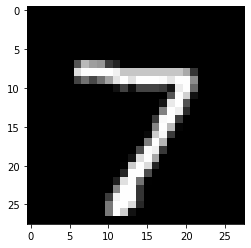

In [4]:
image = test_dataset[0][0]
label = test_dataset[0][1]
print("类别：", label)
plt.imshow(image.reshape(28, 28),cmap = plt.cm.gray)
plt.show()

## 模型加载

In [5]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Training on {}'.format(device))

Training on cuda:1


In [6]:
# 初始化网络
res = model.resnet18().to(device)
# 加载预训练模型
state = torch.load(PATH / "model/resnet18-run-0.pth.tar")
res.load_state_dict(state['state_dict'])
res.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [7]:
# 前向传播，输出网络预测值
def output(sample, net):
    sample = sample.float().to(device)
    output = res(sample).cpu()
    _, pre = torch.max(output.data, 1)
    return pre

# 图片还原
def unnormal(sample, mean, std):
    sample = sample.reshape(28, 28)
    sample = sample*std + mean
    sample = sample.reshape(1, 1, 28, 28)
    return sample

# 保存被攻击的图片
def draw(sample, label, folder, num):
    sample = unnormal(sample, 0.1307, 0.3081)
    sample = sample.to(torch.device('cpu'))
    # 保存被攻击的图片
    id_no = time.strftime('%Y%m%d_%H%M%S', datetime.datetime.now().timetuple())
    vutils.save_image(sample, os.path.join(PATH / "images", folder, "{}_{}_{}.png".format(id_no, label, num)))

In [8]:
# 创建保存图片的文件夹
folder = time.strftime('%Y%m%d_%H%M%S', datetime.datetime.now().timetuple())
os.mkdir(os.path.join(PATH / "images", folder))

# Deepfool攻击

In [11]:
false = 0        # 原网络的分类错误数
correct = 0      # Deepfool攻击后，分类正确的数
total = 0
per_num = 0      #对抗样本个数
per = np.zeros((10000, 28, 28))            # 扰动
loop = []                                  # 迭代次数
per_label = []                             # 对抗样本的标签
per_image = torch.zeros((10000, 28, 28))   # 对抗样本
for images, labels in test_loader:
    total += labels.size(0)
    predicted = output(images, res)
    # 只对分类正确的样本，生成对抗样本
    if predicted==labels:
        r, loop_i, label_orig, label_pert, pert_image = deepfool(images, res, device)
        if label_pert == label_orig:
            correct += 1
        else:
            per[per_num] = r.reshape(28, 28)                  # 扰动
            loop = np.append(loop, loop_i)                    # 迭代次数
            per_label = np.append(per_label, label_pert)      # 对抗样本的标签
            per_image[per_num] =  pert_image.reshape(28, 28)  # 对抗样本
            per_num += 1
    else:
        false += 1
    if total%1000==0:
        print('准确率: %.4f %%' % (100 * correct / total))
print('准确率: %.4f %%' % (100 * correct / total)) 
print('原始准确率: %.4f %%' % (100 * (1 - false / total))) 

准确率: 0.0000 %
准确率: 0.0000 %
准确率: 0.0000 %
准确率: 0.0000 %
准确率: 0.0000 %
准确率: 0.0000 %
准确率: 0.0000 %
准确率: 0.0000 %
准确率: 0.0000 %
准确率: 0.0000 %
准确率: 0.0000 %
原始准确率: 99.5700 %


In [12]:
# 保存对抗样本
for num in range(per_num):
    draw(per_image[num], per_label[num], folder, num)

In [13]:
# 计算扰动大小=扰动的二范数/x的二范数
p_2 = 0
for i in range(per_num):
    r_2 = np.linalg.norm(per[i])
    x = per_image.cpu().numpy()
    x_2 = np.linalg.norm(x[i])
    p_2 += r_2/x_2
p_2 = p_2/per_num
print('二范数扰动：', p_2)

二范数扰动： 0.18409732062160808


原始类别： 3
样本类别： 5.0


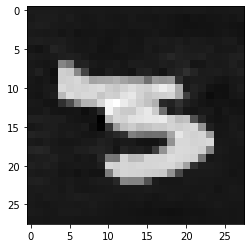

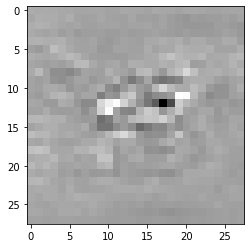

In [14]:
print("原始类别：", label_orig)
print("样本类别：", per_label[per_num-1])
plt.imshow(per_image[per_num-1].reshape(28, 28),cmap = plt.cm.gray)
plt.show()
plt.imshow(per[per_num-1].reshape(28, 28),cmap = plt.cm.gray)
plt.show()